In [62]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import experimentos_sa

import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import json
importlib.reload(experimentos_sa)

<module 'experimentos_sa' from 'c:\\dev\\Busca Heuristica\\T2-BH\\T2\\experimentos_sa.py'>

# Carregamento

In [63]:
def numpy_to_python(obj):
    '''Converte np.int e np.float para int e float dos dados do dicionário'''
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    
def python_to_numpy(dicionario):
    '''Converte int e float para np.int e np.float dos dados do dicionário'''
    for chave, subdict in dicionario.items():
        for subchave, valor in subdict.items():
            if isinstance(valor, int):
                subdict[subchave] = np.int64(valor)
            elif isinstance(valor, float):
                subdict[subchave] = np.float64(valor)
                
    dicionario = {np.int64(key): valor for key, valor in dicionario.items()}
    return dicionario

In [64]:
# Carrega os experimentos do SA
num_calculos_obj = [5000, 10000, 25000, 50000]

caminho_v1 = 'bkp_resultados_sa/sa_v1_experimentos.json'
with open(caminho_v1, 'r', encoding='utf-8') as arquivo:
    v1 = python_to_numpy(json.load(arquivo))
    v1_resultados = experimentos_sa.experimento(v1, num_calculos_obj)
    v1_resultados.calcula_estatisticas()
    
caminho_v2 = 'bkp_resultados_sa/sa_v2_experimentos.json'
with open(caminho_v2, 'r', encoding='utf-8') as arquivo:
    v2 = python_to_numpy(json.load(arquivo))
    v2_resultados = experimentos_sa.experimento(v2, num_calculos_obj)
    v2_resultados.calcula_estatisticas()

# Resultados Simulated Annealing

## Comparações numéricas das vizinhanças e métodos com valor de referência

Valor de referência: R$ 32.170.883

$$Eficiência = \frac{VPL_{Médio}}{VPL_{Referência}}$$

In [65]:
def dicionarios_para_dataframe(dicionarios, nomes):
    dados = []
    indices = []
    for nome, dicionario in zip(nomes, dicionarios):
        for num_calculos, metodos in dicionario.items():
            for metodo, valores in metodos.items():
                indices.append((nome, metodo, num_calculos))
                dados.append([valores["media"], valores["maximo"], valores["minimo"]])
    # Criar o DataFrame com índice no formato de tuplas
    df = pd.DataFrame(dados, 
                      index=pd.MultiIndex.from_tuples(indices, names=["Vn", "Metodo", "NumCalculos"]),
                      columns=["Media", "Maximo", "Minimo"])
    
    # Calcular a eficiência (Média / 32170883)
    df["Eficiência"] = df["Media"] / 32170883
    
    # Definir a exibição de números para evitar notação científica
    pd.set_option('display.float_format', '{:,.3f}'.format)
    
    return df


# Criar o DataFrame
dfs = [v1_resultados.estatisticas, v2_resultados.estatisticas]
nomes = ["Aleatória", "Localizada", "Sistemática"]
df = dicionarios_para_dataframe(dfs, nomes)

# Exibir o DataFrame
df = df[df.index.get_level_values('Metodo') != 'mm']
df
df.groupby(["Vn", "Metodo", "NumCalculos"]).mean()

Media         Maximo         Minimo  \
Vn         Metodo NumCalculos                                                
Aleatória  pm     5000        30,049,511.467 30,325,327.000 29,755,073.000   
                  10000       30,226,367.133 30,439,430.000 30,066,828.000   
                  25000       30,623,788.533 30,903,224.000 30,448,667.000   
                  50000       30,811,727.267 30,939,849.000 30,536,352.000   
Localizada pm     5000        30,016,152.000 30,182,183.000 29,898,104.000   
                  10000       30,203,581.400 30,479,174.000 30,014,130.000   
                  25000       30,544,168.533 30,762,503.000 30,314,710.000   
                  50000       30,797,092.867 30,912,976.000 30,680,261.000   

                               Eficiência  
Vn         Metodo NumCalculos              
Aleatória  pm     5000              0.934  
                  10000             0.940  
                  25000             0.952  
                  50000             0.958  
Localizada pm     5000              0.933  
                  10000             0.939  
                  25000             0.949  
                  50000             0.957

## Comparação dos métodos MM e PM para cada vizinhança

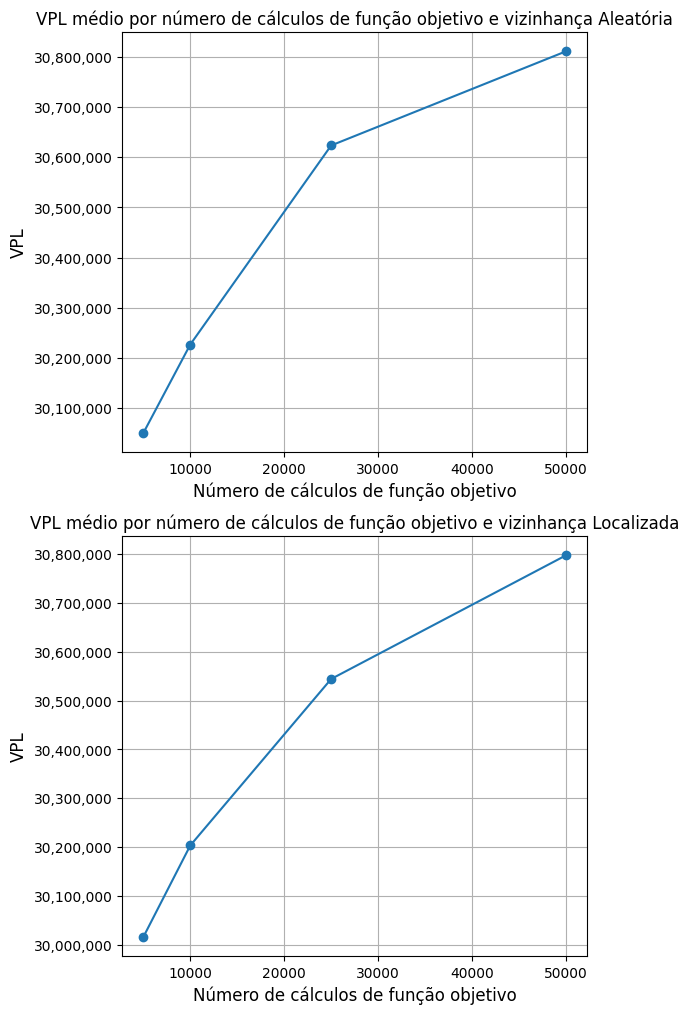

In [66]:
fig, axs = plt.subplots(2,1, figsize=(6,12))
plt.rcParams.update({'font.size': 10})

plt.sca(axs[0])
v1_resultados.plota_experimento(medida='media', vizinhanca='Aleatória')
plt.sca(axs[1])
v2_resultados.plota_experimento(medida='media', vizinhanca='Localizada')

plt.show()

## Comparação do VPL médio das diferentes vizinhanças

In [67]:
# Pega melhor método de cada experimento

v1_mm_media = []
for chave, subdict in v1_resultados.estatisticas.items():
    for subchave, valor in subdict.items():
        if subchave == 'pm':
            v1_mm_media.append(valor.get('media'))
            
v2_mm_media = []
for chave, subdict in v2_resultados.estatisticas.items():
    for subchave, valor in subdict.items():
        if subchave == 'pm':
            v2_mm_media.append(valor.get('media'))
            

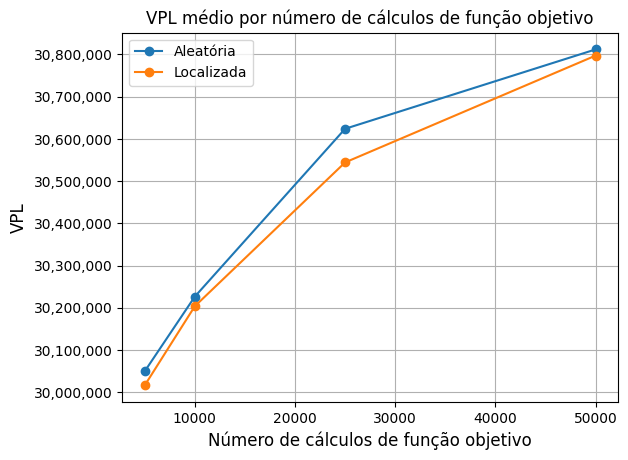

In [68]:
plt.plot(v1_resultados.num_calculos_obj, 
         v1_mm_media, 
         label='Aleatória', 
         marker='o')
plt.plot(v2_resultados.num_calculos_obj, 
         v2_mm_media, 
         label='Localizada', 
         marker='o')

plt.title('VPL médio por número de cálculos de função objetivo')
plt.xlabel('Número de cálculos de função objetivo', fontsize=12)
plt.ylabel('VPL', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.ticklabel_format(style='plain', axis='x') 
plt.legend()
plt.grid()
plt.show()